# Use Random Forest to prepare a model on fraud data, treating those who have taxable_income <= 30000 as "Risky" and others are "Good"
---

## Data Gathering

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
df = pd.read_csv('Fraud_check.csv')
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


We have to convert Taxable.Income into a categorical feature as per the problem statement : 

In [3]:
df['Taxable.Income'] = df['Taxable.Income'].apply(lambda x : 'Risky' if x <= 30000 else 'Good')

## Data Exploration

In [4]:
# Checking for duplicated entries
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


No duplicates

In [5]:
# Renaming column names
df.columns = ['undergrad', 'marital_status', 'taxable_income', 'city_population', 'work_experience', 'urban']

<Axes: xlabel='undergrad', ylabel='count'>

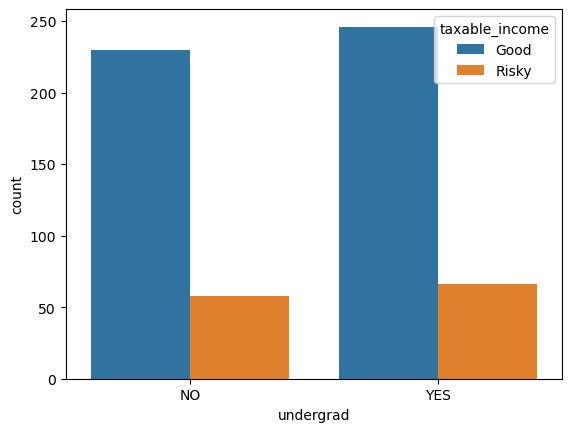

In [6]:
# Countplot for undergrad
sns.countplot(df, x = 'undergrad', hue = 'taxable_income')

<Axes: xlabel='marital_status', ylabel='count'>

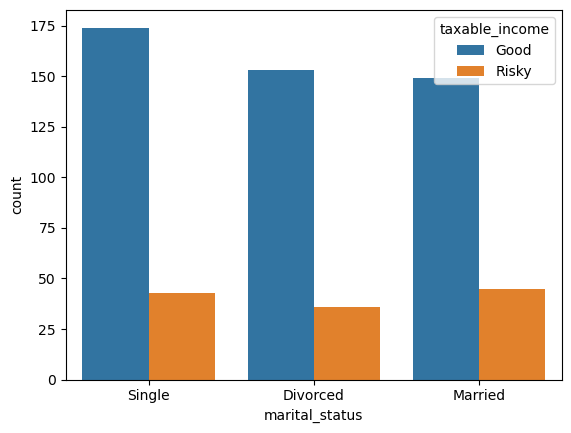

In [7]:
# Countplot for marital_status
sns.countplot(df, x = 'marital_status', hue = 'taxable_income')

<Axes: xlabel='urban', ylabel='count'>

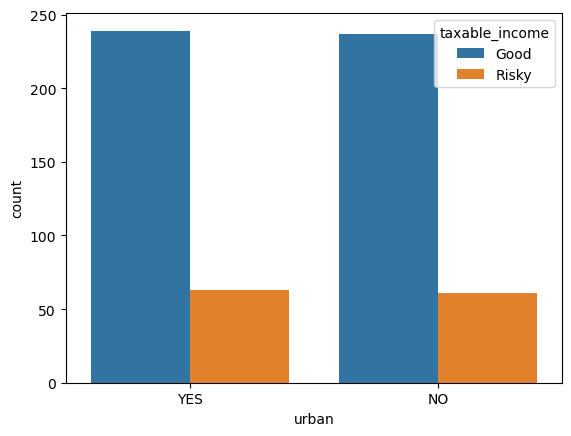

In [8]:
# Countplot for urban
sns.countplot(df, x = 'urban', hue = 'taxable_income')

<Axes: xlabel='city_population', ylabel='Count'>

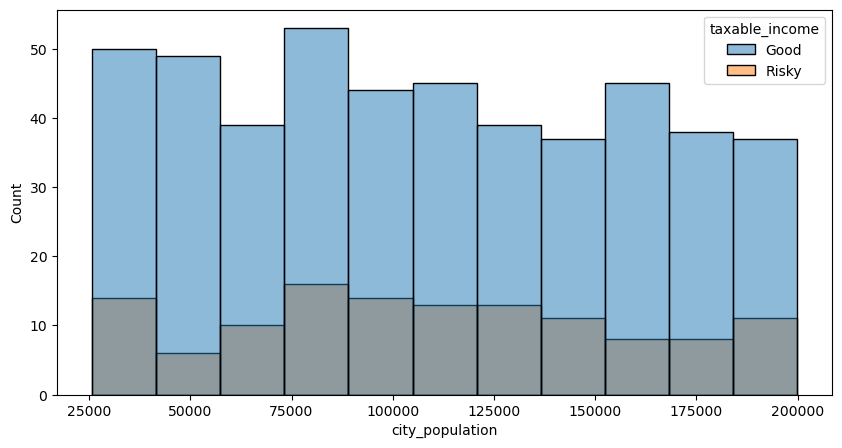

In [9]:
# Histogram for city_population
plt.figure(figsize = (10, 5))
sns.histplot(df, x = 'city_population', hue = 'taxable_income')

<Axes: xlabel='work_experience', ylabel='count'>

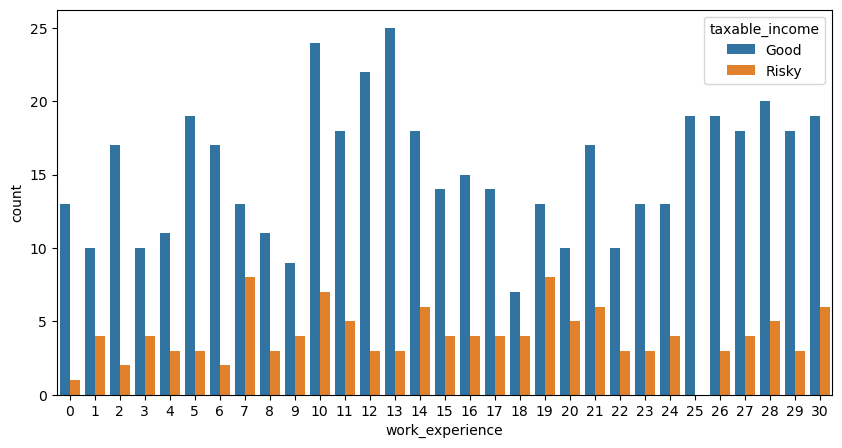

In [10]:
# Histogram for work_experience
plt.figure(figsize = (10, 5))
sns.countplot(df, x = 'work_experience', hue = 'taxable_income')

<Axes: xlabel='taxable_income', ylabel='count'>

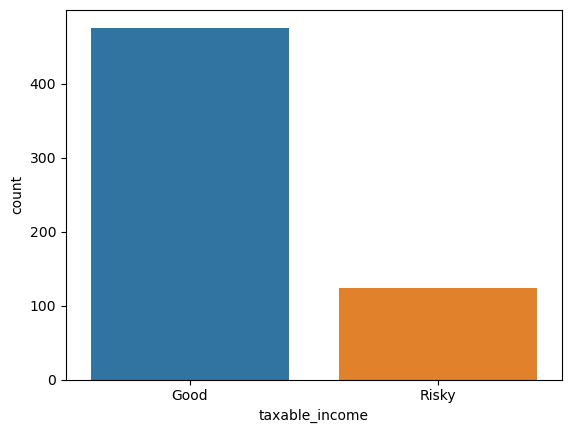

In [11]:
# Countplot for target variable taxable_income
sns.countplot(df, x = 'taxable_income')

In [12]:
# percent count for target variable
df.taxable_income.value_counts(normalize=True)

Good     0.793333
Risky    0.206667
Name: taxable_income, dtype: float64

Target label count is highly imbalanced. 80% entries have non-risky tax bracket. Independent features have somewhat same ratios across categories. 

## Feature Engineering

In [13]:
# binarizing binary features
df.undergrad.replace({'NO':0, 'YES':1}, inplace= True)
df.taxable_income.replace({'Risky':1, 'Good':0}, inplace= True)
df.urban.replace({'NO':0, 'YES':1}, inplace= True)

In [14]:
# Getting dummies for categorical feature marital_status
df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)

In [15]:
# Normalizing work_experience
from sklearn.preprocessing import MinMaxScaler
df['work_experience'] = MinMaxScaler().fit_transform(df['work_experience'].to_numpy().reshape(-1,1))
df['city_population'] = MinMaxScaler().fit_transform(df['city_population'].to_numpy().reshape(-1,1))

## Hyperparameter Tuning

In [16]:
# Importing required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [17]:
# Splitting data into dependent and independent variables
X = df.drop(columns='taxable_income')
y = df.taxable_income

In [18]:
# Splitting data into stratified train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [19]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [20]:
# Fitting to Random Forest Classifier
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [21]:
# Getting out-of-bag score
rfc.oob_score_

0.7488888888888889

In [22]:
# Getting training accuracy
rfc.score(X_train, y_train)

1.0

In [23]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.7666666666666667

Note that the best score was 73% in the previous assignment using Decision Trees Classifier. 76.6% is an improvement on it. Let us try a few different hyperparameters in a grid search to get the best combination

In [24]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200],
    'criterion' : ["gini", "entropy"],
    'max_features' : [i for i in range(1, X.shape[1] + 1)],
    'class_weight' :["balanced", "balanced_subsample", None] 
}

In [25]:
# Creating Stratified K Fold Cross Validator
skf = StratifiedKFold()

In [26]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state= 42)

In [27]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs = -1, cv = skf, verbose = 3)

In [28]:
# Running grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             verbose=3)

In [29]:
# Getting best score from grid search
grid.best_score_

0.7688888888888888

In [30]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 4,
 'n_estimators': 10}

It is surprising to see that the best n_estimators value is such a small number. Let us try again with smaller values for n_estimators in the grid search

In [31]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [5, 10, 15, 20, 25, 30, 35, 40, 45],
    'criterion' : ["gini", "entropy"],
    'max_features' : [i for i in range(1, X.shape[1] + 1)],
    'class_weight' :["balanced", "balanced_subsample", None] 
}

In [32]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs = -1, cv = skf)

In [33]:
# Running grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45]})

In [34]:
# Getting best score from grid search
grid.best_score_

0.7688888888888888

In [35]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 4,
 'n_estimators': 10}

Let us use these hyperparameter values and check test score again

In [36]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(n_estimators= 10, max_features= 4, class_weight='balanced', oob_score = True, n_jobs = -1, random_state= 42)

In [37]:
# Fitting training data to the model
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=4, n_estimators=10,
                       n_jobs=-1, oob_score=True, random_state=42)

In [38]:
# Getting out-of-bag score
rfc.oob_score_

0.72

In [39]:
# Score for training data
rfc.score(X_train, y_train)

0.9466666666666667

In [40]:
# Score for testing data
rfc.score(X_test, y_test)

0.76

In [41]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.96      0.86       119
           1       0.00      0.00      0.00        31

    accuracy                           0.76       150
   macro avg       0.39      0.48      0.43       150
weighted avg       0.62      0.76      0.69       150



Target class 1 has 0 precision and recall

In [42]:
# Value count of each target class
y_test.value_counts()

0    119
1     31
Name: taxable_income, dtype: int64

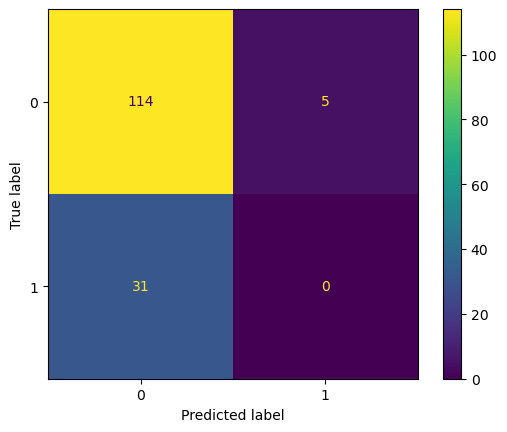

In [43]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

All of the 31 samples with 1 target class have been misclassified. Our model is misclassifying all samples of class 1 as class 0, and few of class 0 as class 1

In [44]:
# Creating a function that takes n_estimators and max_features, and returns oob_score, training and testing scores, classification report, and confusion matrix

def display_model_quality(n_estimators, max_features = 4, class_weight='balanced'): 
    print("*********************************************************")
    print(f"\tn_estimators = {n_estimators}\t\tmax_features = {max_features}")
    print("*********************************************************")
    rfc = RandomForestClassifier(n_estimators= n_estimators, max_features= max_features, class_weight=class_weight, oob_score = True, n_jobs = -1, random_state= 42)
    rfc.fit(X_train, y_train)
    print(f"\nTRAINING SCORE : {rfc.score(X_train, y_train)}")
    print(f"OOB SCORE : {rfc.oob_score_}")
    print(f"TESTING SCORE : {rfc.score(X_test, y_test)}")
    print(f"\n---CLASSIFICATION REPORT---\n{classification_report(y_test, rfc.predict(X_test))}")
    print("\n---CONFUSION MATRIX---")
    ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

*********************************************************
	n_estimators = 100		max_features = 4
*********************************************************

TRAINING SCORE : 1.0
OOB SCORE : 0.7466666666666667
TESTING SCORE : 0.7733333333333333

---CLASSIFICATION REPORT---
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       119
           1       0.20      0.03      0.06        31

    accuracy                           0.77       150
   macro avg       0.50      0.50      0.46       150
weighted avg       0.67      0.77      0.70       150


---CONFUSION MATRIX---


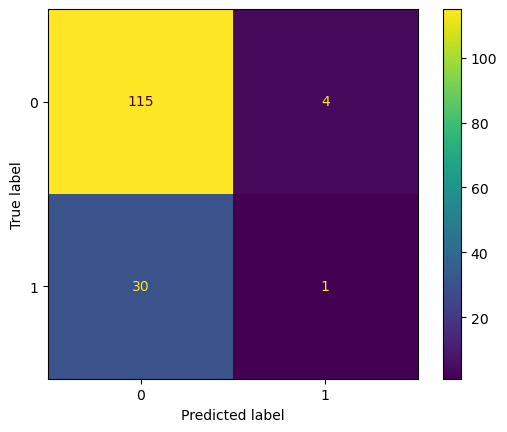

In [45]:
# Stats for n_estimators = 100 and max_features = 4
display_model_quality(100, 4)

*********************************************************
	n_estimators = 100		max_features = 4
*********************************************************

TRAINING SCORE : 1.0
OOB SCORE : 0.7422222222222222
TESTING SCORE : 0.7666666666666667

---CLASSIFICATION REPORT---
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       119
           1       0.17      0.03      0.05        31

    accuracy                           0.77       150
   macro avg       0.48      0.50      0.46       150
weighted avg       0.66      0.77      0.70       150


---CONFUSION MATRIX---


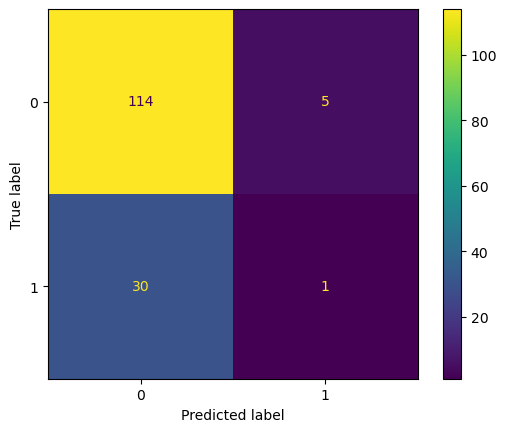

In [46]:
# Stats for n_estimators = 100 and max_features = 4, and class_weight = None
display_model_quality(100, 4, None)

*********************************************************
	n_estimators = 100		max_features = 4
*********************************************************

TRAINING SCORE : 1.0
OOB SCORE : 0.7377777777777778
TESTING SCORE : 0.78

---CLASSIFICATION REPORT---
              precision    recall  f1-score   support

           0       0.80      0.97      0.87       119
           1       0.33      0.06      0.11        31

    accuracy                           0.78       150
   macro avg       0.57      0.52      0.49       150
weighted avg       0.70      0.78      0.72       150


---CONFUSION MATRIX---


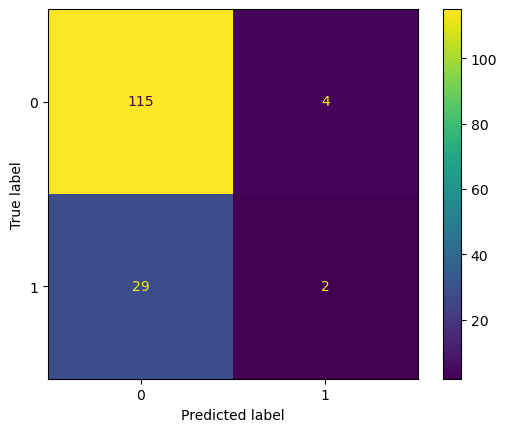

In [47]:
# Stats for n_estimators = 100 and max_features = 4, and class_weight = balanced_subsample
display_model_quality(100, 4, 'balanced_subsample')

Even with 100 n_estimators, the model barely classifies 2 True Positives

Let us try grid search again, with 'f1' as the scoring metric

In [48]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [5, 10, 50, 100, 200, 500, 750, 900, 1000],
    'criterion' : ["gini", "entropy"],
    'max_features' : [i for i in range(1, X.shape[1] + 1)],
    'class_weight' :["balanced", "balanced_subsample", None] 
}

In [49]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state= 42)

In [52]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs = -1, cv = skf, scoring = 'f1')

In [53]:
# Running grid search
grid.fit(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [5, 10, 50, 100, 200, 500, 750, 900,
                                          1000]},
             scoring='f1')

In [54]:
# Getting best score from grid search
grid.best_score_

0.14638487208008902

In [55]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 6,
 'n_estimators': 5}

In [56]:
# Checking cross validation results
pd.DataFrame(grid.cv_results_).drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']).sort_values('rank_test_score').head(20)

,param_class_weight,param_criterion,param_max_features,param_n_estimators,mean_test_score,std_test_score,rank_test_score
99,balanced,entropy,6,5,0.146385,0.076955,1
207,balanced_subsample,entropy,6,5,0.118772,0.059715,2
216,None,gini,1,5,0.117369,0.086446,3
100,balanced,entropy,6,10,0.116577,0.070237,4
162,balanced_subsample,entropy,1,5,0.115776,0.098757,5
126,balanced_subsample,gini,3,5,0.115442,0.067030,6
217,None,gini,1,10,0.100470,0.066688,7
243,None,gini,4,5,0.096516,0.067990,8
252,None,gini,5,5,0.093988,0.036088,9
315,None,entropy,6,5,0.091300,0.058118,10


We can see that the f1 score is only 14% for the best hyperparameter combination. Also, while class weights, criterion, and max_features change, the top score are obtained for 5 and 10 as n_estimators. Let us run grid search again for lower values for n_estimators

In [57]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [x for x in range(3,16)],
    'criterion' : ["gini", "entropy"],
    'max_features' : [i for i in range(1, X.shape[1] + 1)],
    'class_weight' :["balanced", "balanced_subsample", None] 
}

In [58]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(n_jobs = -1, random_state= 42)

In [59]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs = -1, cv = skf, scoring = 'f1')

In [60]:
# Running grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15]},
             scoring='f1')

In [61]:
# Getting best score from grid search
grid.best_score_

0.16268620268620268

In [62]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': 5,
 'n_estimators': 3}

In [63]:
# Checking cross validation results
pd.DataFrame(grid.cv_results_).drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']).sort_values('rank_test_score').head(20)

,param_class_weight,param_criterion,param_max_features,param_n_estimators,mean_test_score,std_test_score,rank_test_score
364,None,gini,5,3,0.162686,0.061456,1
312,None,gini,1,3,0.149442,0.081498,2
145,balanced,entropy,6,5,0.146385,0.076955,3
123,balanced,entropy,4,9,0.132353,0.108604,4
338,None,gini,3,3,0.124498,0.039835,5
149,balanced,entropy,6,9,0.123869,0.066532,6
121,balanced,entropy,4,7,0.123633,0.090079,7
403,None,entropy,2,3,0.123047,0.052170,8
313,None,gini,1,4,0.119817,0.088334,9
301,balanced_subsample,entropy,6,5,0.118772,0.059715,10


In [64]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(max_features = 5, oob_score = True, n_jobs = -1, random_state= 42)

*********************************************************
	n_estimators = 3		max_features = 5
*********************************************************

TRAINING SCORE : 0.9266666666666666
OOB SCORE : 0.6955555555555556
TESTING SCORE : 0.6266666666666667

---CLASSIFICATION REPORT---
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       119
           1       0.07      0.06      0.07        31

    accuracy                           0.63       150
   macro avg       0.41      0.42      0.42       150
weighted avg       0.62      0.63      0.62       150


---CONFUSION MATRIX---


C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


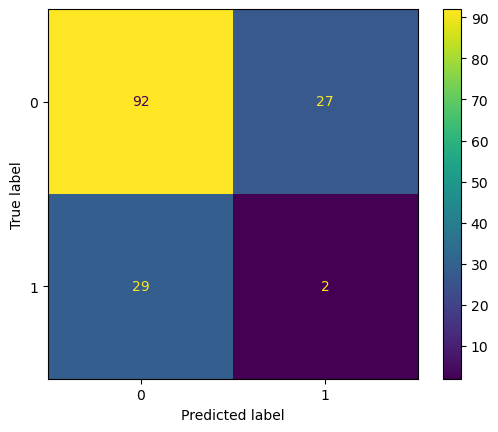

In [65]:
# Stats for n_estimators = 3 and max_features = 5, and class_weight = None
display_model_quality(3, 5, None)

We still have barely 2 correctly classifier True values

Let us try again without normalizing the continuous features

In [66]:
# Loading data into a separate dataframe
df2 = pd.read_csv('Fraud_check.csv')

In [67]:
# Categorizing target variable for new dataframe
df2['Taxable.Income'] = df2['Taxable.Income'].apply(lambda x : 'Risky' if x <= 30000 else 'Good')

In [68]:
# Applying same transformation to new dataframe, except Normalizing continuous features, and splitting into independent and dependent variables
df2.columns = ['undergrad', 'marital_status', 'taxable_income', 'city_population', 'work_experience', 'urban']
df2.undergrad.replace({'NO':0, 'YES':1}, inplace= True)
df2.taxable_income.replace({'Risky':1, 'Good':0}, inplace= True)
df2.urban.replace({'NO':0, 'YES':1}, inplace= True)
df2 = pd.get_dummies(df2, columns=['marital_status'], drop_first=True)
X = df2.drop(columns='taxable_income')
y = df2.taxable_income

In [69]:
# Splitting data into stratified train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [70]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [71]:
# Fitting to Random Forest Classifier
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [72]:
# Getting out-of-bag score
rfc.oob_score_

0.7511111111111111

In [73]:
# Getting training accuracy
rfc.score(X_train, y_train)

1.0

In [74]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.7666666666666667

In [75]:
# Printing classification report
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.96      0.87       119
           1       0.17      0.03      0.05        31

    accuracy                           0.77       150
   macro avg       0.48      0.50      0.46       150
weighted avg       0.66      0.77      0.70       150



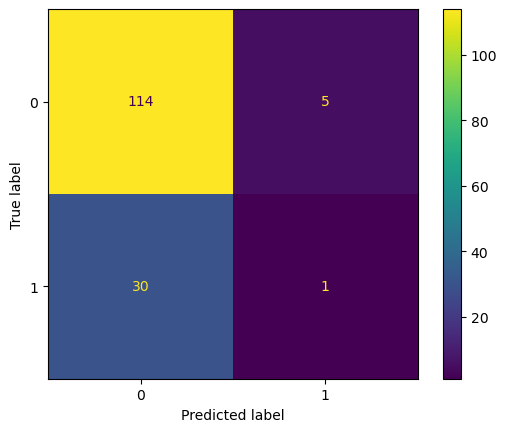

In [76]:
# Plotting confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

Not normalizing the continuous features didn't help

In [77]:
# Feature importances
pd.DataFrame(rfc.feature_names_in_, rfc.feature_importances_)

,0
0.038848,undergrad
0.502405,city_population
0.357481,work_experience
0.038577,urban
0.030864,marital_status_Married
0.031825,marital_status_Single


## Balancing Dataset

Let us balance the data and check f1 score

In [78]:
# Importing dataset balancing techniques from imblearn
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [79]:
# Splitting data into stratified train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

### ADASYN

In [80]:
X_adasyn, y_adasyn = ADASYN(random_state=42, n_jobs = -1).fit_resample(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [81]:
y_adasyn.value_counts()

1    379
0    357
Name: taxable_income, dtype: int64

In [82]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [83]:
# Fitting to Random Forest Classifier
rfc.fit(X_adasyn, y_adasyn)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [84]:
# Getting out-of-bag score
rfc.oob_score_

0.7269021739130435

In [85]:
# Getting training accuracy
rfc.score(X_adasyn, y_adasyn)

1.0

In [86]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.5333333333333333

In [87]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.61      0.67       119
           1       0.15      0.26      0.19        31

    accuracy                           0.53       150
   macro avg       0.45      0.43      0.43       150
weighted avg       0.63      0.53      0.57       150



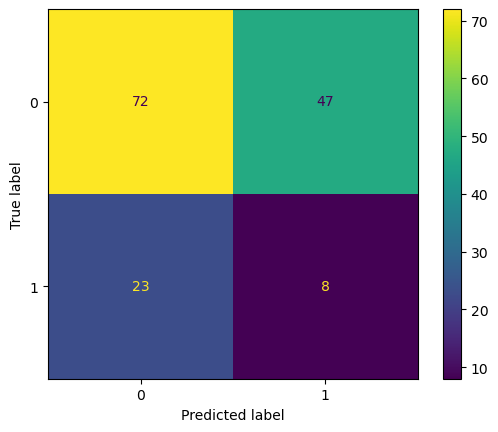

In [88]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

### SMOTE

In [89]:
X_smote, y_smote = SMOTE(random_state=42, n_jobs = -1).fit_resample(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [90]:
y_smote.value_counts()

1    357
0    357
Name: taxable_income, dtype: int64

In [91]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [92]:
# Fitting to Random Forest Classifier
rfc.fit(X_smote, y_smote)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [93]:
# Getting out-of-bag score
rfc.oob_score_

0.7002801120448179

In [94]:
# Getting training accuracy
rfc.score(X_smote, y_smote)

1.0

In [95]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.5066666666666667

In [96]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       119
           1       0.14      0.26      0.18        31

    accuracy                           0.51       150
   macro avg       0.44      0.41      0.41       150
weighted avg       0.62      0.51      0.55       150



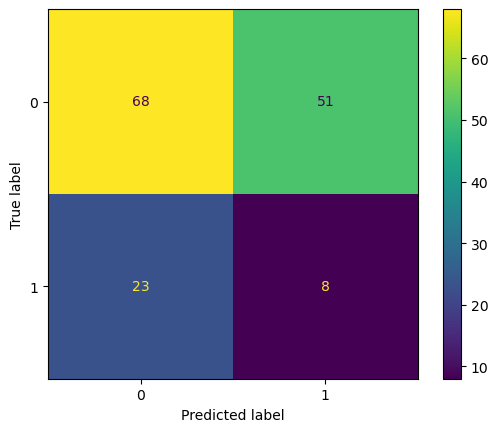

In [97]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

### SMOTEENN

In [98]:
X_smoteenn, y_smoteenn = SMOTEENN(random_state=42, n_jobs = -1).fit_resample(X_train, y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [99]:
y_smoteenn.value_counts()

1    99
0    95
Name: taxable_income, dtype: int64

In [100]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [101]:
# Fitting to Random Forest Classifier
rfc.fit(X_smoteenn, y_smoteenn)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [102]:
# Getting out-of-bag score
rfc.oob_score_

0.7371134020618557

In [103]:
# Getting training accuracy
rfc.score(X_smoteenn, y_smoteenn)

1.0

In [104]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.56

In [105]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69       119
           1       0.18      0.32      0.23        31

    accuracy                           0.56       150
   macro avg       0.48      0.47      0.46       150
weighted avg       0.66      0.56      0.60       150



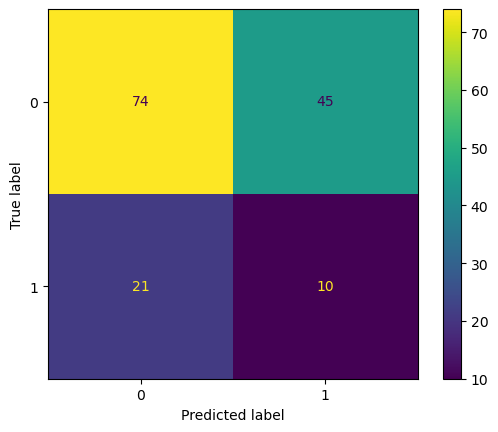

In [106]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

### SMOTETomek

In [107]:
X_st, y_st = SMOTETomek(random_state=42, n_jobs = -1).fit_resample(X_train,y_train)

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [108]:
y_st.value_counts()

1    262
0    262
Name: taxable_income, dtype: int64

In [109]:
# Creating a Random Forest Classifier
rfc = RandomForestClassifier(max_features = 'sqrt', oob_score = True, n_jobs = -1, random_state= 42, class_weight='balanced_subsample')

In [110]:
# Fitting to Random Forest Classifier
rfc.fit(X_st, y_st)

RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       oob_score=True, random_state=42)

In [111]:
# Getting out-of-bag score
rfc.oob_score_

0.6946564885496184

In [112]:
# Getting training accuracy
rfc.score(X_st, y_st)

1.0

In [113]:
# Getting test accuracy
rfc.score(X_test, y_test)

0.5333333333333333

In [114]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       119
           1       0.16      0.29      0.20        31

    accuracy                           0.53       150
   macro avg       0.46      0.44      0.44       150
weighted avg       0.64      0.53      0.57       150



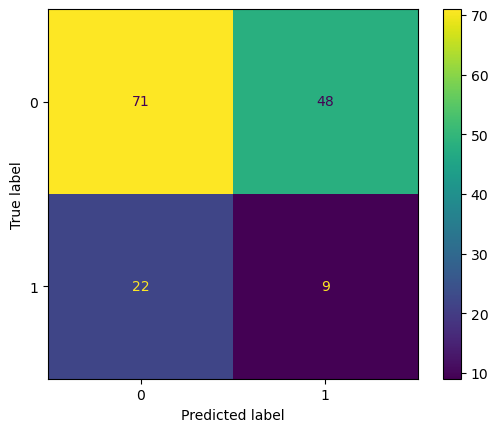

In [115]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

SMOTEENN gave us the best accuracy. Let us apply grid search for data balanced with SMOTEENN to find the optimal hyperparameters

In [116]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200],
    'criterion' : ["gini", "entropy"],
    'max_features' : [i for i in range(1, X.shape[1] + 1)],
    'class_weight' :["balanced", "balanced_subsample", None] 
}

In [117]:
# Creating Stratified K Fold Cross Validator
skf = StratifiedKFold()

In [118]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(n_jobs = -1, random_state= 42)

In [119]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring = 'f1', n_jobs = -1, cv = skf)

In [120]:
# Running grid search
grid.fit(X_smoteenn, y_smoteenn)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='f1')

In [121]:
# Getting best score from grid search
grid.best_score_

0.8094144776176002

In [122]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 6,
 'n_estimators': 100}

In [123]:
# Checking cross validation results
pd.DataFrame(grid.cv_results_).drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']).sort_values('rank_test_score').head(20)

,param_class_weight,param_criterion,param_max_features,param_n_estimators,mean_test_score,std_test_score,rank_test_score
87,balanced_subsample,gini,6,100,0.809414,0.088760,1
119,balanced_subsample,entropy,6,200,0.806987,0.096539,2
118,balanced_subsample,entropy,6,150,0.806307,0.092239,3
89,balanced_subsample,gini,6,200,0.805466,0.088226,4
149,None,gini,6,200,0.801907,0.102556,5
29,balanced,gini,6,200,0.801907,0.102556,5
25,balanced,gini,6,10,0.801409,0.117735,7
55,balanced,entropy,6,10,0.800325,0.092239,8
115,balanced_subsample,entropy,6,10,0.798379,0.097406,9
88,balanced_subsample,gini,6,150,0.797855,0.085724,10


max_features = 6, and class_weights = 'balanced_subsample' are the hyperparameters for the top scoring models from the grid. entropy keeps changing and n_estimators keep fluctuating between 100 and 200

In [124]:
# Defining parameter values for grid search
param_grid = {
    'n_estimators' : [i for i in range(75, 300, 5)],
    'criterion' : ["gini", "entropy"],
    'max_features' : [6],
    'class_weight' :["balanced_subsample"] 
}

In [125]:
# Creating a Grid Search object
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs = -1, scoring = 'f1', cv = skf)

In [126]:
# Running grid search
grid.fit(X_smoteenn, y_smoteenn)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['gini', 'entropy'], 'max_features': [6],
                         'n_estimators': [75, 80, 85, 90, 95, 100, 105, 110,
                                          115, 120, 125, 130, 135, 140, 145,
                                          150, 155, 160, 165, 170, 175, 180,
                                          185, 190, 195, 200, 205, 210, 215,
                                          220, ...]},
             scoring='f1')

In [127]:
# Getting best score from grid search
grid.best_score_

0.8131797046386412

In [128]:
# Getting parameter that gave the best score
grid.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_features': 6,
 'n_estimators': 130}

Let us use these hyperparameter values and check test score again

## Model Training and Testing

In [129]:
# Redifining Random Forest Classifier for grid search
rfc = RandomForestClassifier(n_estimators= 130, max_features= 6, class_weight='balanced_subsample', oob_score = True, n_jobs = -1, random_state= 42)

In [130]:
# Fitting training data to the model
rfc.fit(X_smoteenn, y_smoteenn)

RandomForestClassifier(class_weight='balanced_subsample', max_features=6,
                       n_estimators=130, n_jobs=-1, oob_score=True,
                       random_state=42)

In [131]:
# Getting out-of-bag score
rfc.oob_score_

0.8350515463917526

In [132]:
# Score for training data
rfc.score(X_smoteenn, y_smoteenn)

1.0

In [133]:
# Score for testing data
rfc.score(X_test, y_test)

0.5533333333333333

In [134]:
# Classification report for testing data predictions
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.61      0.69       119
           1       0.18      0.32      0.23        31

    accuracy                           0.55       150
   macro avg       0.48      0.47      0.46       150
weighted avg       0.65      0.55      0.59       150



In [135]:
# Value count of each target class
y_test.value_counts()

0    119
1     31
Name: taxable_income, dtype: int64

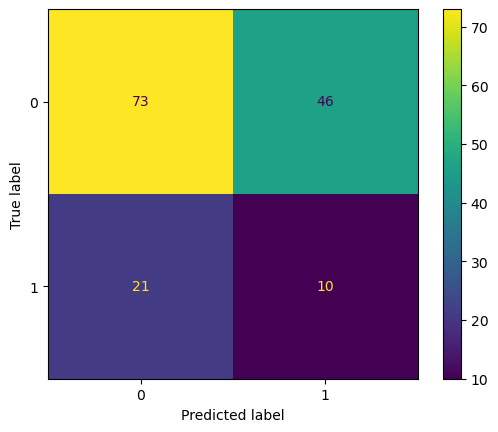

In [136]:
# Confusion Matrix for test data predictions
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

## Conclusion

- With normalized continuous features, we got an abysmal accuracy score of upto 15%
- Hyperparameter Tuning did not help
- Then, we checked without normalizing the continuous feature, which resulted in barely any improvement
- The models were classifying atmost 2 samples as target class 1
- This was due to imbalanced target labels
- We tried 4 over and under sampling techniques from imblearn, and found SMOTEENN gave the best accuracy
- We used Hyperparameter Tuning to get the optimal hyperparameter values but precision and recall for target class 1 are still very low
- This could be due to our small dataset